# Training ResNets on CIFAR-10
In this project, you will use the ResNets model to perform image classification on CIFAR-10. CIFAR-10 orginally contains 60K images from 10 categories. We split it into 45K/5K/10K images to serve as train/valiation/test set. We only release the ground-truth labels of training/validation dataset to you.

## Step 0: Set up the ResNets model
As you have practiced to implement simple neural networks in Homework 1, we just prepare the implementation for you.

In [1]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# define the ResNets mode;
class BasicBlock(nn.Module):
    expansion = 4
    def __init__(self,input1,output,kernel,s,downsample=None):
        super(BasicBlock,self).__init__()
        self.conv1 = nn.Conv2d(input1,output,kernel,stride =s ,padding = 1)
        self.conv1bn = nn.BatchNorm2d(output)
        self.conv2 = nn.Conv2d(output,output,kernel,stride =1 ,padding = 1)
        self.conv2bn = nn.BatchNorm2d(output)
        self.shortcut = nn.Sequential()
        self.out_filter = output
        self.stride = s
        self.downsample = downsample
    def forward(self,x):
        out = self.conv1(x)
        out = F.relu(self.conv1bn(out))
        out = self.conv2(out)
        # if self.stride != 1:
        #     x = F.pad(x[:, :, ::2, ::2], [0, 0, 0, 0, self.out_filter // 4, self.out_filter // 4], "constant", 0)
        residual = x
        if self.downsample:
            residual = self.downsample(x)
    
        out = self.conv2bn(out) + residual
#         out = out+x
        out = F.relu(out)
        return out
class ResNets(nn.Module):
    def __init__(self):
        super(ResNets,self).__init__()
        self.conv1 = nn.Conv2d(3,16,3,stride =1 ,padding = 1)
        self.block1 = self.make_layers(3,16,16,3,1)
        self.block2 = self.make_layers(3,16,32,3,2)
        self.block3 = self.make_layers(3,32,64,3,2)
        self.fc = nn.Linear(64,10)
    def make_layers(self, num_block, input1, output,kernel, s):
        layers = []
        downsample = None
        if s != 1 or input1 != output:
            downsample = nn.Sequential(nn.Conv2d(input1, output, kernel, stride=s,padding=1),
                nn.BatchNorm2d(output))
        for i in range(num_block):
            if i == 0:
                layers.append(BasicBlock(input1, output,kernel, s,downsample))
            else:
                layers.append(BasicBlock(output, output,kernel, 1))
        return nn.Sequential(*layers)
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = F.avg_pool2d(out,out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = F.softmax(out, dim=1) # Force the output to be in (0, 1), otherwise beta function cannot work

        assert ~((0 in out) or (1 in out)), 'softmax output breaks'

        return out

## Step 1: Set up preprocessing functions
Preprocessing is very important as discussed in the lecture.
You will need to write preprocessing functions with the help of *torchvision.transforms* in this step.
You can find helpful tutorial/API at [here](https://pytorch.org/vision/stable/transforms.html).

### Question (b)
For the question, you need to:
1. Complete the preprocessing code below.
2. **In the PDF report**, briefly describe what preprocessing operations you used and what are the purposes of them.

Hint: 
1. Only two operations are necessary to complete the basic preprocessing here.
2. The raw input read from the dataset will be PIL images.
3. Data augmentation operations are not mendatory, but feel free to incorporate them if you want.
4. Reference value for mean/std of CIFAR-10 images (assuming the pixel values are within [0,1]): mean (RGB-format): (0.4914, 0.4822, 0.4465), std (RGB-format): (0.2023, 0.1994, 0.2010)

In [3]:
# useful libraries
import torchvision
import torchvision.transforms as transforms

#############################################
# your code here
# specify preprocessing function
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=(32,32),padding = 4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
#############################################

## Step 2: Set up dataset and dataloader

### Question (c)
Set up the train/val datasets and dataloders that are to be used during the training. Check out the [official API](https://pytorch.org/docs/stable/data.html) for more information about **torch.utils.data.DataLoader**.

Here, you need to:
1. Complete the code below.

In [4]:
# do NOT change these
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

#############################################
# your code here
from torchvision.transforms import ToTensor
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT, 
    mode='train', 
    download=True,
    transform=transform_train    # your code
)
val_set = CIFAR10(
    root=DATA_ROOT, 
    mode='val', 
    download=True,
    transform=transform_val     # your code
)
test_set = CIFAR10(
    root=DATA_ROOT, 
    mode='test', 
    download=True,
    transform=transform_val
)
# construct dataloader
train_loader = DataLoader(
    train_set, 
    batch_size=TRAIN_BATCH_SIZE,  # your code
    shuffle=True,     # your code
    num_workers=4
)
print(len(train_set))
print("iter num " ,len(train_loader))
val_loader = DataLoader(
    val_set, 
    batch_size=VAL_BATCH_SIZE,  # your code
    shuffle= True,     # your code
    num_workers=4
)
test_loader = DataLoader(
    test_set, batch_size=100, shuffle=False, num_workers=1)
#############################################

Using downloaded and verified file: ./data/cifar10_trainval_F21.zip
Extracting ./data/cifar10_trainval_F21.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F21.zip
Extracting ./data/cifar10_trainval_F21.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_test_F21.zip
Extracting ./data/cifar10_test_F21.zip to ./data
Files already downloaded and verified
45000
iter num  352


## Step 3: Instantiate your ResNets model and deploy it to GPU devices.
### Question (d)
You may want to deploy your model to GPU device for efficient training. Please assign your model to GPU if possible. If you are training on a machine without GPUs, please deploy your model to CPUs.

Here, you need to:
1. Complete the code below.
2. **In the PDF report**, briefly describe how you verify that your model is indeed deployed on GPU. (Hint: check $\texttt{nvidia-smi}$.)

In [5]:
# specify the device for computation
#############################################
# your code here
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Model Definition  
net = ResNets()
net = net.to(device)
print('Using device:', device)
# nvidia-smi
#############################################

Using device: cuda


## Step 4: Set up the loss function and optimizer
Loss function/objective function is used to provide "feedback" for the neural networks. Typically, we use multi-class cross-entropy as the loss function for classification models. As for the optimizer, we will use SGD with momentum. 

### Question (e)
Here, you need to:
1. Set up the cross-entropy loss as the criterion. (Hint: there are implemented functions in **torch.nn**)
2. Specify a SGD optimizer with momentum. (Hint: there are implemented functions in **torch.optim**)

In [6]:
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import MultiStepLR
# hyperparameters, do NOT change right now
# initial learning rat
INITIAL_LR = 0.1

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4
# REG = 5e-4

#############################################
# your code here
# create loss function
criterion = nn.CrossEntropyLoss()

# Add optimizer
optimizer = optim.SGD(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM,weight_decay=REG,nesterov=True)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1,threshold = 1e-4,patience=8, verbose=True)
# Scheduler based on the paper "Batch shaping" for cifar-10 with ResNet-20
# scheduler = MultiStepLR(optimizer, milestones=[300, 375, 450], gamma=0.1)
#############################################

## Step 5: Start the training process.

### Question (f)/(g)
Congratulations! You have completed all of the previous steps and it is time to train our neural network.

Here you need to:
1. Complete the training codes.
2. Actually perform the training.

Hint: Training a neural network usually repeats the following 4 steps: 

**i) Get a batch of data from the dataloader and copy it to your device (GPU).**

**ii) Do a forward pass to get the outputs from the neural network and compute the loss. Be careful about your inputs to the loss function. Are the inputs required to be the logits or softmax probabilities?)**

**iii) Do a backward pass (back-propagation) to compute gradients of all weights with respect to the loss.**

**iiii) Update the model weights with the optimizer.**

You will also need to compute the accuracy of training/validation samples to track your model's performance over each epoch (the accuracy should be increasing as you train for more and more epochs).

In [7]:
# from scipy.stats import beta as sci_beta
from scipy.stats import betabinom as sci_beta
N = 1000

In [8]:
# Batch shaping loss
# @brief A function compute batch shaping loss based on beta CDF
# @param x: gating output
# @param gamma: loss factor
# @param alpha, beta: Beta distribution parameters
# @param batch_size: batch size
# @reutrn loss: batch shaping loss

# Loss stregth from the paper, alpha, beta from wiki
GAMMA=0.75
ALPHA=0.5
BETA=ALPHA
# BETA=5

# def bs_loss(x, gamma, alpha, beta, batch_size):
#     loss = 0
#     x_dup = x.clone().detach().cpu().numpy()
#     for i in range(x.shape[0]):
#         x_sort = np.sort(x_dup[i].flatten()) # TODO: Check for dimension correctness
#         p_cdf = sci_beta.cdf(x_sort, alpha, beta)
#         e_cdf = np.linspace(1, 1+batch_size, 1) / (batch_size+1)
#         loss = loss + np.sum(np.power(e_cdf - p_cdf, 2)).item()
#     return loss * gamma

In [9]:
# Customized loss function: Batch shaping loss

class Batch_Shaping_Loss(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, gamma, alpha, beta, batch_size):

        assert torch.max(x) <= 1 or torch.min(x) >= 0, \
            'output values after softmax should be in (0, 1),'\
            ' beta func only produce meaningful output with input in (0, 1),'\
            ' output max = {}, min = {}'.format(torch.max(x), torch.min(x))


        loss = 0
        loss = torch.autograd.Variable(torch.tensor(loss))
        x_dup = x.clone().detach().cpu().numpy()

        # x_dup = F.softmax(x_dup)

        p_cdf_list = []
        p_pdf_list = []
        e_cdf_list = []
        x_idx_list = []
        
        for i in range(x.shape[0]):
            x_sort = np.sort(x_dup[i].flatten()) # TODO: Check for dimension correctness
            x_idx = np.argsort(x_dup[i].flatten())
            # p_cdf = sci_beta.cdf(x_sort, alpha, beta)
            p_cdf = sci_beta.cdf(N,x_sort, alpha, beta)
            e_cdf = np.linspace(1, 1+batch_size, 1) / (batch_size+1)
            loss = loss + np.sum(np.power(e_cdf - p_cdf, 2)).item()
            
            
            # Store for backward
            assert ~((1 in x_sort) or (0 in x_sort)), 'input of pdf breaks'
            # p_pdf = sci_beta.pdf(x_sort, alpha, beta)
            p_pdf = sci_beta.pmf(N,x_sort, alpha, beta)
            
            p_cdf_list.append(torch.tensor(p_cdf))
            p_pdf_list.append(torch.tensor(p_pdf))
            e_cdf_list.append(torch.tensor(e_cdf))
            x_idx_list.append(torch.tensor(x_idx))
        
        # Save parameter for backward use
        # The function only accpets Variable as input, stack all tensors in a list
        p_cdf_stack = torch.stack(p_cdf_list)
        p_pdf_stack = torch.stack(p_pdf_list)
        e_cdf_stack = torch.stack(e_cdf_list)
        x_idx_stack = torch.stack(x_idx_list)
        ctx.save_for_backward(p_cdf_stack, p_pdf_stack, e_cdf_stack, x_idx_stack)
        
        assert ~torch.isnan(loss), 'loss should not be nan'
        
        return loss * gamma
    @staticmethod
    def backward(ctx, grad):
        # Read parameter from backward
        p_cdf_stack, p_pdf_stack, e_cdf_stack, x_idx_stack = ctx.saved_tensors
        # Split the stack into lists of tensors
        p_cdf_list = list(torch.split(p_cdf_stack, 1))
        p_pdf_list = list(torch.split(p_pdf_stack, 1))
        e_cdf_list = list(torch.split(e_cdf_stack, 1))
        x_idx_list = list(torch.split(x_idx_stack, 1))

        bs_grad_list = []
        for i in range(len(p_cdf_list)):
            # Remove redundant dimension (caused by stacking) by squeezing
            p_cdf = torch.squeeze(p_cdf_list[i]).numpy()
            p_pdf = torch.squeeze(p_pdf_list[i]).numpy()
            e_cdf = torch.squeeze(e_cdf_list[i]).numpy()
            x_idx = torch.squeeze(x_idx_list[i]).numpy()
            p_pdf = np.nan_to_num(p_pdf)
            assert ~np.any(~np.isfinite(p_cdf)), 'p_cdf error, value = {}'.format(p_cdf)
            assert ~np.any(~np.isfinite(p_pdf)), 'p_pdf error, value = {}'.format(p_pdf)
            assert ~np.any(~np.isfinite(e_cdf)), 'e_cdf error, value = {}'.format(e_cdf)
            # bs_grad = -2 * p_pdf * (e_cdf - p_cdf)
            bs_grad = -2 * (e_cdf - p_cdf)
            bs_grad = np.nan_to_num(bs_grad)
            # Undo sort
            bs_grad_unsort = [bs_grad[i] for i in x_idx]
            bs_grad_list.append(torch.tensor(bs_grad_unsort))
        # The function is not using imput grad since it
        # is applied at the end of the model as a loss funciton
        bs_grad_stack = torch.autograd.Variable(torch.stack(bs_grad_list))
        bs_grad_stack = bs_grad_stack.to(device)
        assert ~torch.any(~torch.isfinite(bs_grad_stack)), 'gradient should not be too large, now is {}'.format(torch.max(bs_grad_stack))
        assert ~torch.any(torch.isnan(bs_grad_stack)), 'gradient should not be nan'
        return bs_grad_stack, None, None, None, None

bs_loss = Batch_Shaping_Loss.apply

In [10]:
# some hyperparameters
# total number of training epochs
EPOCHS = 80
# learning rate decay policy

# the folder where the trained model is saved
CHECKPOINT_PATH = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR
print_total_loss = [[],[]]
print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    # handle the learning rate scheduler.
    
    #######################
    # your code here
    # switch to train mode
    net.train()
    print("\nEpoch [{}/{}]".format(i+1, EPOCHS))
    #######################
    
    print("Epoch %d:" %(i+1))
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want
    
    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        out = net(inputs)
        out = torch.nan_to_num(out)
        assert ~torch.any(torch.isnan(out)), 'network output should not be nan'
        loss = criterion(out,targets) + bs_loss(out, GAMMA, ALPHA, BETA, TRAIN_BATCH_SIZE)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _,predicted = torch.max(out, 1)
        correct = predicted.eq(targets).sum()
        train_loss+=loss
        total_examples+=targets.shape[0]
        correct_examples += correct.item()
        ####################################
                
    avg_loss = train_loss / len(train_loader)
    train_avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, train_avg_acc))
#     print(train_avg_acc)

    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()
    
    
    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0
    
    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            out = net(inputs)
            loss = criterion(out,targets)
            _,predicted = torch.max(out, 1)
            correct = predicted.eq(targets).sum()
            val_loss+=loss
            total_examples+=targets.shape[0]
            correct_examples += correct.item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    scheduler.step(avg_loss)
    print_total_loss[0].append(train_avg_acc)
    print_total_loss[1].append(avg_acc)
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_PATH):
            os.makedirs(CHECKPOINT_PATH)
        print("Saving ...")
        state = {'state_dict': net.state_dict(),
                 'epoch': i,
                 'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_PATH, 'ResNets_v2.pth'))
        
    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

net.eval()
results = []
with torch.no_grad():
    for inputs in (test_loader):
        inputs = inputs.to(device)
        # Generate output from the DNN.
        outputs = net(inputs)        
        # Calculate predicted labels
        _, predicted = torch.max(out, 1)
        results.append(predicted.detach().cpu().numpy())
results = np.array(results).flatten()
with open('predictions_%.4f.csv'%(best_val_acc), 'w') as fp:
    fp.write("Id,Label\n")
    for i in range(len(results)):
        fp.write("%d,%d\n" %(i, results[i]))

==> Training starts!

Epoch [1/80]
Epoch 1:
Training loss: 946.1249, Training accuracy: 0.3253
Validation loss: 2.1176, Validation accuracy: 0.3340
Saving ...


Epoch [2/80]
Epoch 2:
Training loss: 946.0096, Training accuracy: 0.4470
Validation loss: 2.0180, Validation accuracy: 0.4352
Saving ...


Epoch [3/80]
Epoch 3:
Training loss: 945.9365, Training accuracy: 0.5226
Validation loss: 1.9416, Validation accuracy: 0.5142
Saving ...


Epoch [4/80]
Epoch 4:
Training loss: 945.9007, Training accuracy: 0.5577
Validation loss: 1.9472, Validation accuracy: 0.5074


Epoch [5/80]
Epoch 5:
Training loss: 945.8679, Training accuracy: 0.5906
Validation loss: 1.9206, Validation accuracy: 0.5378
Saving ...


Epoch [6/80]
Epoch 6:
Training loss: 945.8464, Training accuracy: 0.6134
Validation loss: 1.8462, Validation accuracy: 0.6142
Saving ...


Epoch [7/80]
Epoch 7:
Training loss: 945.8057, Training accuracy: 0.6558
Validation loss: 1.8454, Validation accuracy: 0.6162
Saving ...


Epoch [8/80]
Epo

# Load Model

In [14]:
# the folder where the trained model is saved
CHECKPOINT_PATH = "./saved_model"

net = ResNets()
net = net.to(device)
checkpoint = torch.load(os.path.join(CHECKPOINT_PATH, 'ResNets_v2.pth'))
net.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

## Test the model and plot the distribution

In [21]:
import matplotlib.pyplot as plt

def plot_dist(x):
    x_dup = x.clone().detach().cpu().numpy()
    for i in range(x.shape[0]):
        x_sort = np.sort(x_dup[i].flatten())
        p_cdf = sci_beta.cdf(N, x_sort, ALPHA, BETA)
        print(x_sort)
        plt.hist(x_sort, histtype=u'step', bins=10); plt.show(); plt.close()
        plt.hist(x_sort, histtype=u'step', bins=10, cumulative=True); plt.show(); plt.close()
        print(p_cdf)
        plt.hist(p_cdf, histtype=u'step', bins=10); plt.show(); plt.close()
        plt.hist(p_cdf, histtype=u'step', bins=10, cumulative=True); plt.show(); plt.close()


[2.47594480e-13 3.01211174e-11 3.13196274e-11 4.58187967e-11
 1.10792965e-10 5.23349453e-09 1.87675457e-08 1.91827553e-07
 6.54435155e-07 9.99999166e-01]


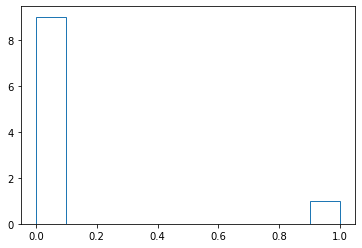

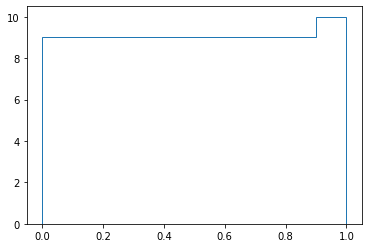

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


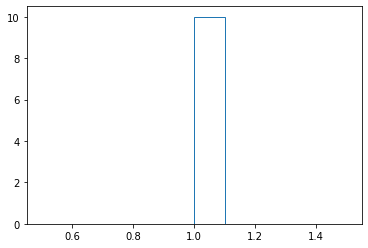

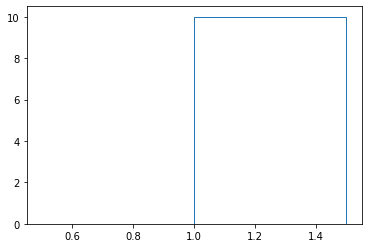

[8.4337914e-09 7.0730657e-08 1.1147463e-07 1.3485962e-07 2.5220817e-07
 9.5139524e-07 1.4173850e-05 1.6549115e-05 2.1522391e-01 7.8474379e-01]


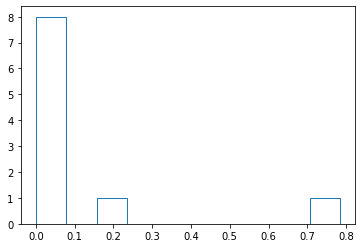

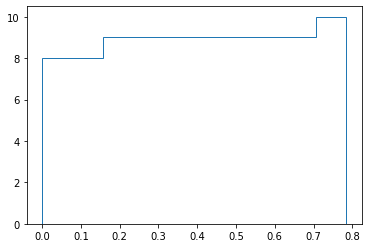

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


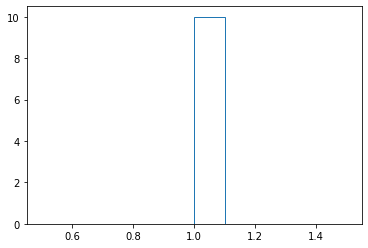

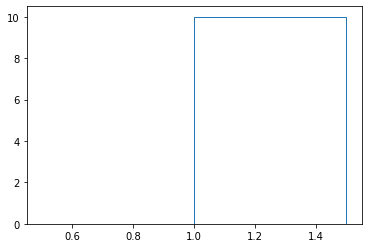

[2.77573164e-09 1.29945716e-08 1.03780394e-07 1.54204983e-07
 2.09930050e-07 9.24602318e-06 2.84392627e-05 8.68444768e-05
 2.32456233e-02 9.76629317e-01]


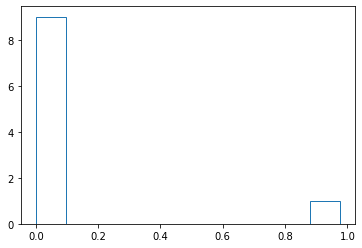

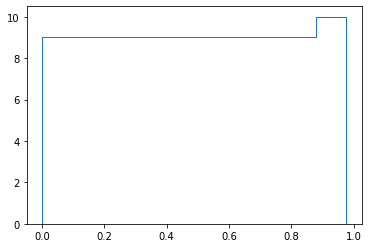

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


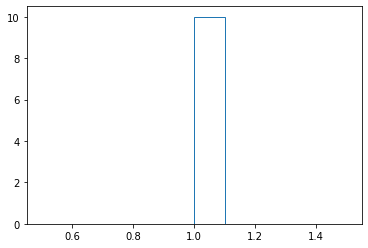

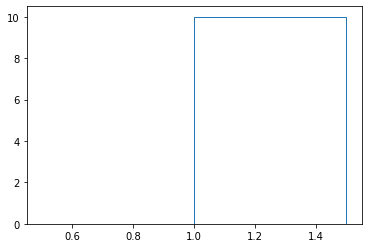

[1.0128168e-11 6.5521748e-11 6.7704869e-11 5.0773663e-10 1.2676280e-09
 6.5025070e-09 1.3048328e-08 2.9635880e-08 5.9185027e-08 1.0000000e+00]


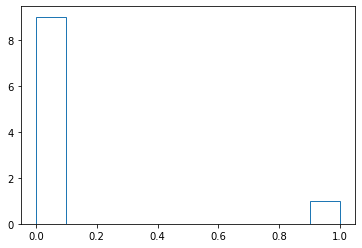

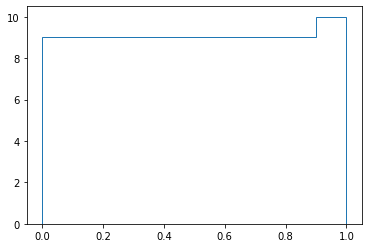

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


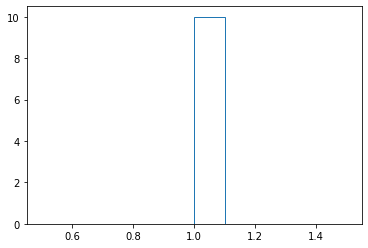

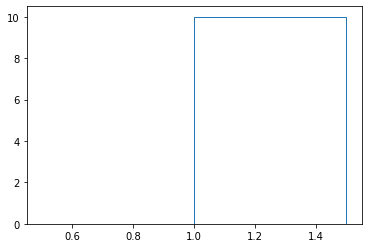

[8.2612979e-11 9.8452357e-10 1.7061440e-09 1.9377706e-09 9.4463752e-09
 4.5738474e-08 4.2642951e-06 6.6234215e-06 5.7970770e-05 9.9993110e-01]


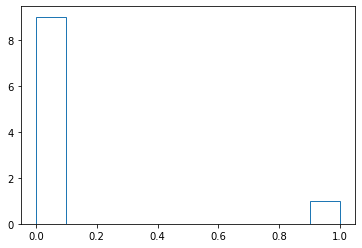

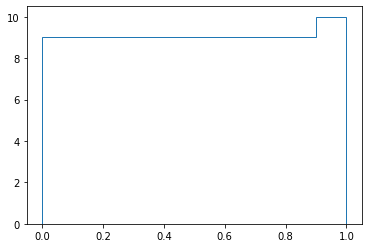

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


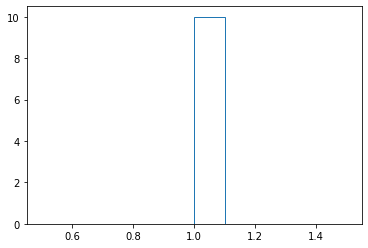

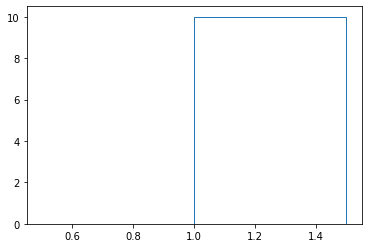

[4.2757535e-14 5.4422385e-14 7.9168985e-14 3.1250255e-13 5.4235159e-13
 1.7961828e-11 9.8440445e-10 1.0449403e-07 9.9343913e-07 9.9999893e-01]


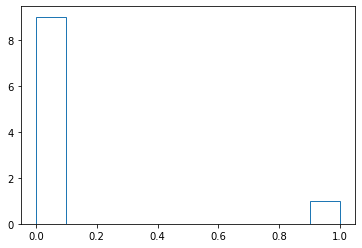

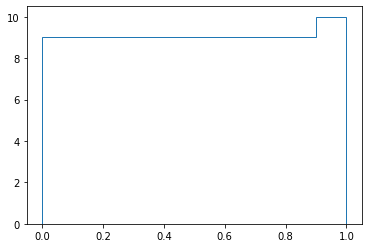

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


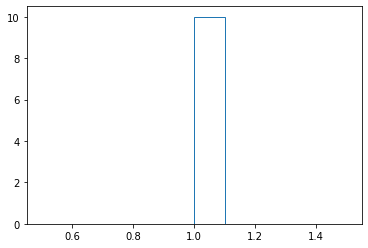

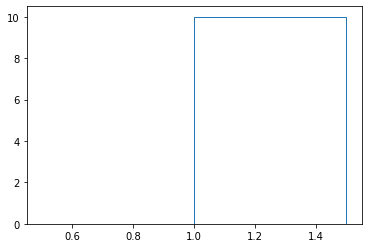

[4.5864777e-13 6.2264652e-13 3.1840171e-12 9.2200310e-11 1.1127061e-10
 6.8141104e-10 9.5296182e-10 4.3693666e-09 5.3078420e-08 1.0000000e+00]


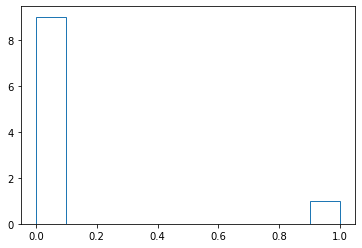

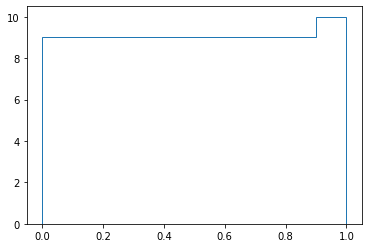

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


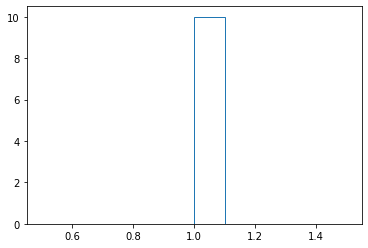

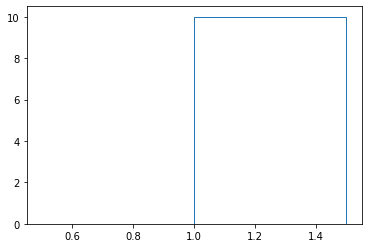

[2.6558317e-10 7.1291101e-10 8.9373375e-10 1.0201349e-09 1.3360028e-08
 2.2873204e-08 5.5048059e-08 7.5575360e-07 4.3558341e-01 5.6441575e-01]


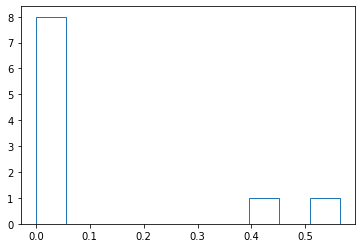

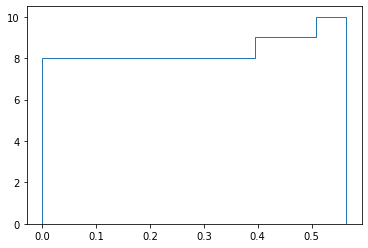

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


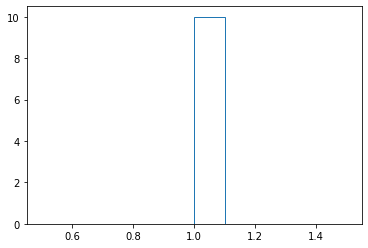

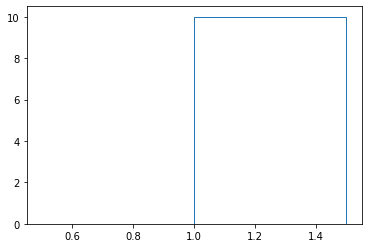

[1.6654625e-15 1.4482500e-14 3.1215845e-13 7.7160110e-13 1.8816123e-12
 2.5358719e-12 1.9757550e-10 2.7538698e-07 1.8535808e-06 9.9999785e-01]


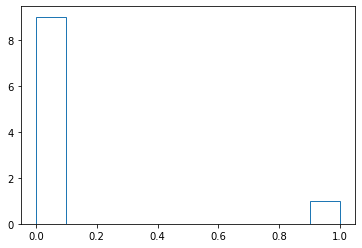

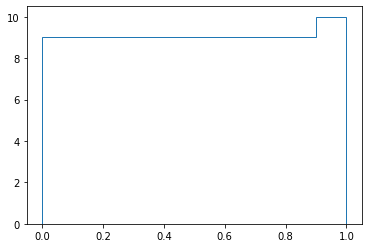

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


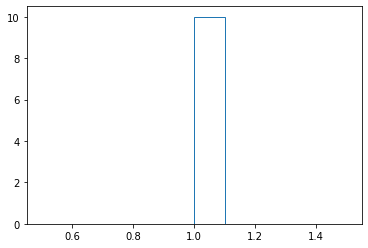

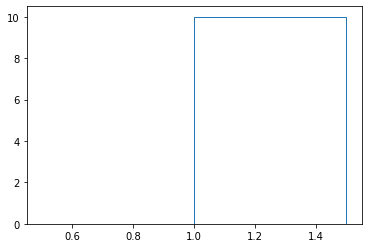

[9.8320104e-17 4.2764085e-15 1.9700203e-14 3.2183091e-14 1.8882450e-13
 2.2949093e-13 8.2617008e-13 2.3339239e-12 3.3893315e-11 1.0000000e+00]


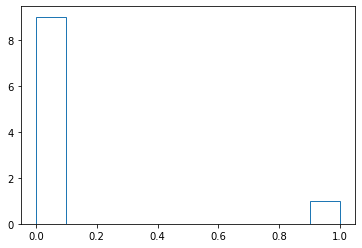

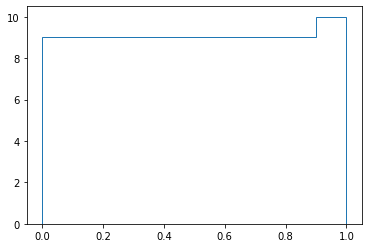

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


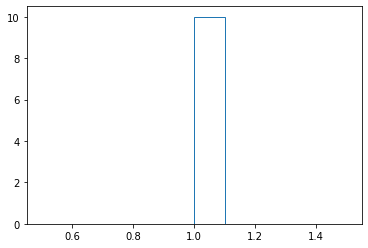

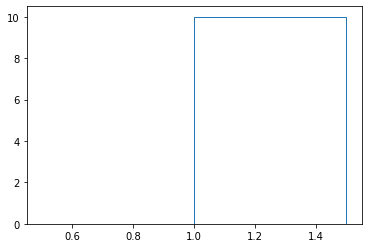

[8.28587348e-14 1.00779411e-13 1.02820435e-13 2.08185289e-13
 1.44476434e-12 1.74869526e-12 3.89561827e-10 8.49700643e-10
 1.98460559e-09 1.00000000e+00]


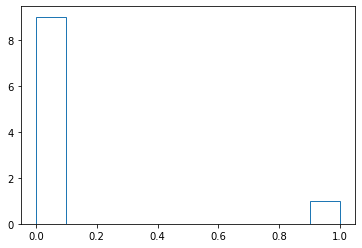

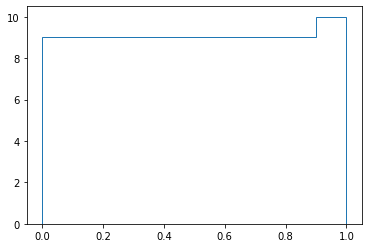

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


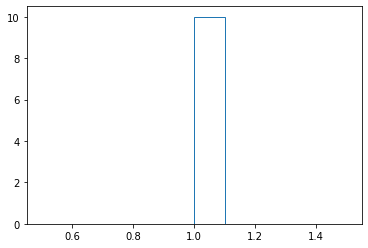

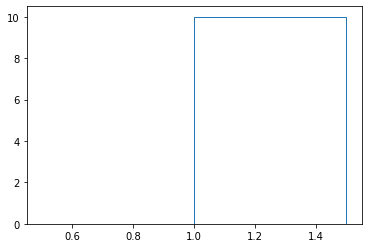

[1.7894967e-10 4.7572785e-10 8.1049456e-10 3.9756602e-09 7.5233260e-09
 1.1365095e-08 1.9395761e-08 5.7786661e-08 8.0250878e-08 9.9999988e-01]


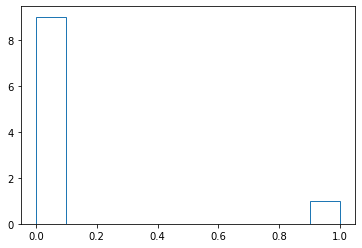

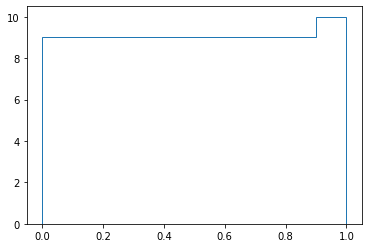

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


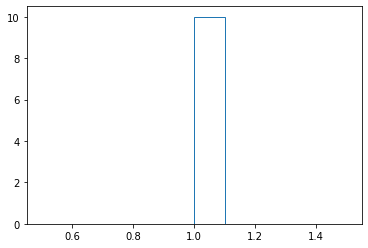

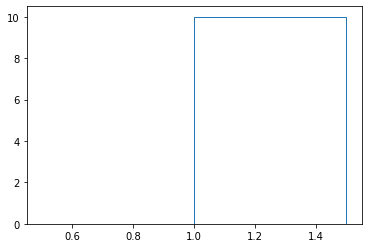

[2.4345497e-17 3.0426562e-17 3.8952110e-17 5.9726821e-17 6.9597727e-16
 8.0810892e-16 3.1146833e-15 5.0503869e-15 2.1193615e-13 1.0000000e+00]


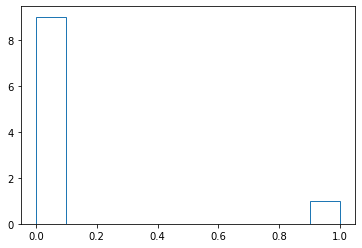

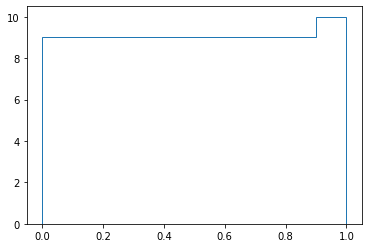

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


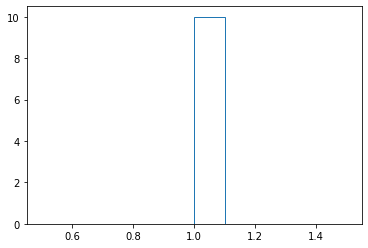

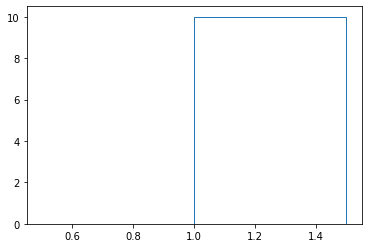

[3.8379903e-14 7.3336451e-14 1.3374074e-13 2.8177691e-13 1.8360782e-12
 6.3642763e-12 7.2707999e-11 2.1339666e-08 1.4544979e-06 9.9999857e-01]


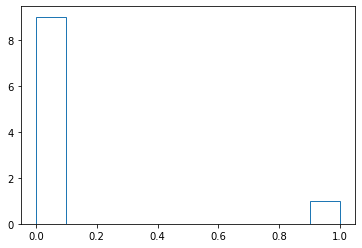

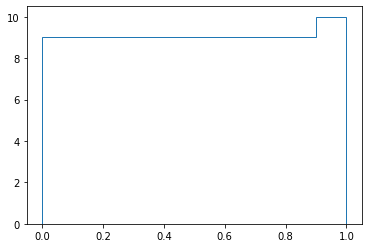

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


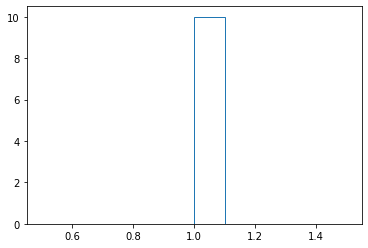

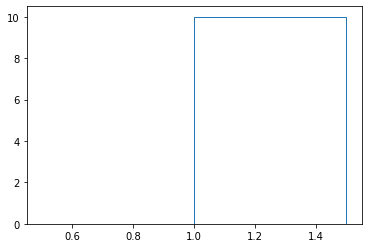

[1.7098409e-14 2.3636050e-14 1.9136759e-13 2.2915063e-13 4.9719603e-13
 9.0796413e-13 2.6494688e-12 1.9317095e-11 1.0551661e-10 1.0000000e+00]


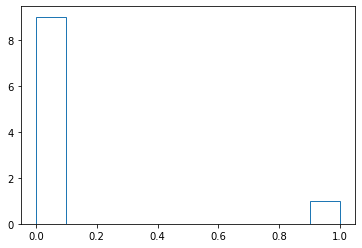

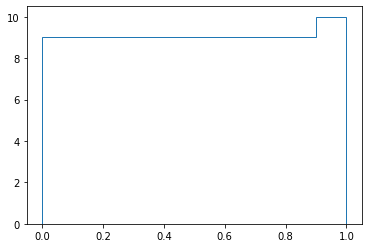

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


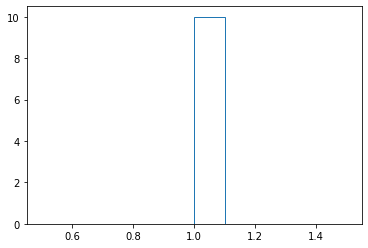

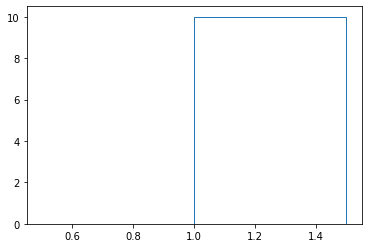

[4.43151948e-05 1.49742744e-04 3.78718076e-04 8.08311743e-04
 1.82859122e-03 9.62466095e-03 1.36984736e-02 9.83852074e-02
 1.00503705e-01 7.74578214e-01]


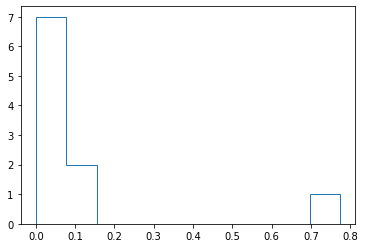

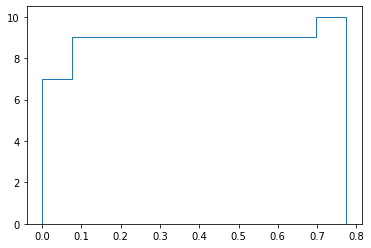

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


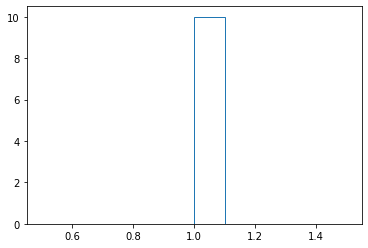

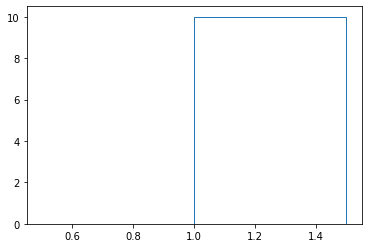

[1.0771613e-10 1.4631675e-10 3.4439147e-09 5.0838214e-08 1.9338925e-07
 1.9617962e-06 4.9969756e-05 3.7957475e-04 2.8396375e-02 9.7117180e-01]


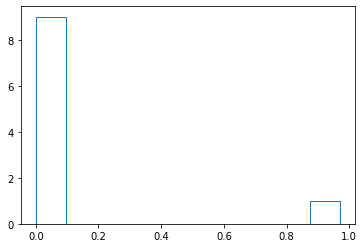

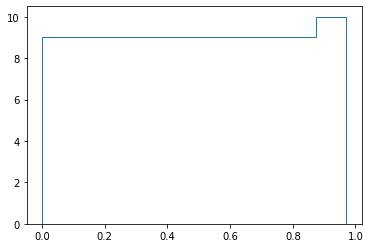

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


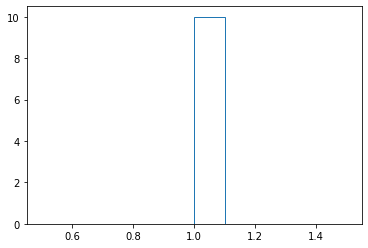

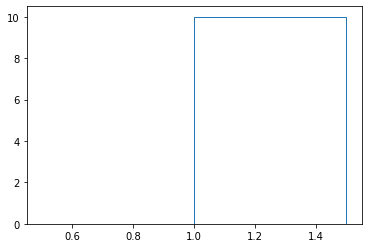

[3.5515327e-16 2.3063157e-15 6.9067740e-15 2.2764888e-14 2.6721413e-14
 7.4034068e-14 2.6220701e-12 1.0537808e-09 1.0306221e-08 1.0000000e+00]


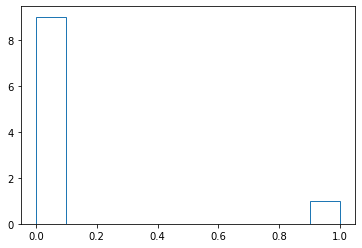

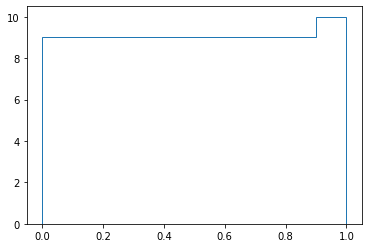

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


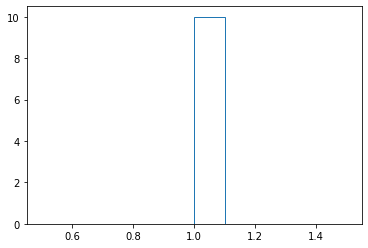

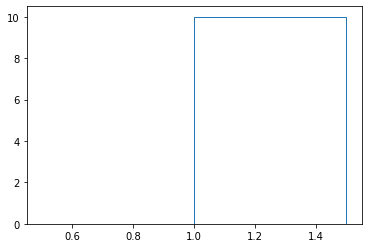

[1.4595719e-08 1.0832151e-07 7.4840915e-07 8.3832560e-07 8.8340045e-07
 4.1737494e-06 7.3084748e-06 6.4591834e-05 1.7162344e-03 9.9820507e-01]


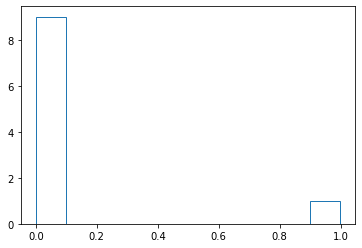

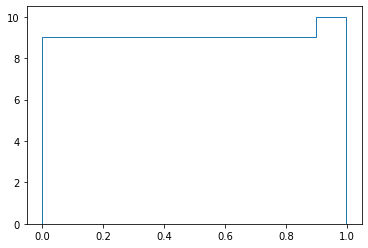

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


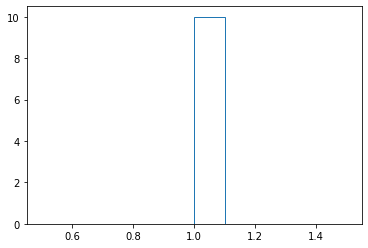

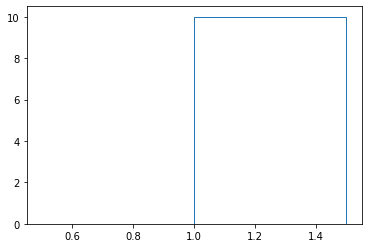

[4.1136646e-15 1.5291554e-14 4.2959166e-14 1.7049894e-13 2.2508780e-13
 1.8238887e-12 3.5238544e-12 3.6518098e-12 2.2157354e-10 1.0000000e+00]


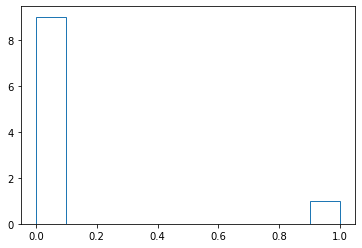

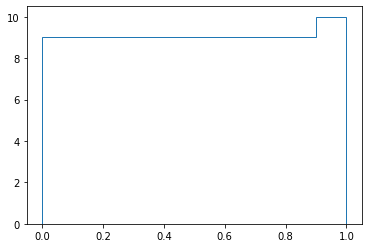

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


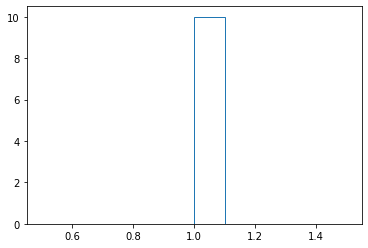

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [22]:
# Validate on the validation dataset

# switch to eval mode
net.eval()

# this help you compute the validation accuracy
total_examples = 0
correct_examples = 0

val_loss = 0 # again, track the validation loss if you want

# disable gradient during validation, which can save GPU memory
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(val_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # compute the output and loss
        outputs = net(inputs)
        plot_dist(outputs)
        if batch_idx > 0:
            break
        loss = criterion(outputs, targets)
        
        # count the number of correctly predicted samples in the current batch
        _, predicted = outputs.max(1)
        total_examples += predicted.size(0)
        correct_examples += predicted.eq(targets).sum().item()
        val_loss += loss
        ####################################

avg_loss = val_loss / len(val_loader)
avg_acc = correct_examples / total_examples
print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    